In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier, zeroes_classifier

PATH = "../"
# To run all computation, change to True. Otherwise, precomputed files will be loaded instead.
compute_all = False
# If running, ensure the following line is commented out. It disables plots for knitting to html purposes. 
#%matplotlib agg

# Set seed for reproducibility
np.random.seed(420) 
# Path to outputs folder
OUT_PATH = PATH + "report_outputs/"
# Path to data
IN_PATH = PATH + "Datasets/data/"
# Path to other file dependencies
DEP_PATH = PATH + "requirements/other_files/"


In [4]:
offsets = {"data1":0,
           "data2":0,
           "data3":0,
           "data4":0,
           "data5":-5,
           "data6":0,
           "data7":-1,
           "data8":0}

def load_data(path, fnames, scale_factor = 1, shift_factor = -512):
    waves = {}
    labels = {}
    for file in fnames:
        # Load in wave file
        samprate, wav_array = wavfile.read(path+file+".wav")
        wav_array = wav_array*scale_factor
        wav_array += shift_factor
        
        # Fix the bug in alessandro's code
        fixed_wav = []
        step = 999
        offset = offsets[file]
        for j, i in enumerate(range(offset, len(wav_array)-step, step)):
            if j == 0:
                fixed_wav.append(np.flip(wav_array[0:i+step]))
            fixed_wav.append(np.flip(wav_array[i:i+step]))

        waves[file] = np.concatenate(fixed_wav)
        # Load in label file
        labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)
        labels_dat.columns = ["label", "time"]
        labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
        labels[file] = labels_dat
    print(f"Successfully loaded {len(waves)} wavefiles:")
    print("\n".join(sorted(waves.keys())))
    return waves, labels

fnames = ["data1", "data2", "data3", "data4", "data5", "data6", "data7", "data8"]

# Randomly select two files for the test set, remainder as training
test_files = np.random.choice(fnames, 2, replace=False)
training_files = list(set(fnames) - set(test_files))

# Training Data
waves, labels = load_data(
    IN_PATH, training_files, scale_factor = 1, shift_factor = -512)

# Test Data
test_waves, test_labels = load_data(
    IN_PATH, test_files, scale_factor = 1, shift_factor = -512)

# Define Sample Rate: 10,000 Hz
samprate = 10_000


time_buffers = {"data3":(-0.3, 0.55),
                "data2":(-0.3, 0.55),
                "data0":(-0.3, 0.55),
                "data1":(-0.3, 0.55),
                "data5":(-0.5, 0.75),
                "data4":(-0.5, 0.75)}

Successfully loaded 6 wavefiles:
data1
data2
data3
data4
data6
data8
Successfully loaded 2 wavefiles:
data5
data7
<ipython-input-4-5eed2c68d2fd>:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)


In [5]:
def my_lev_dist(prediction, actual, sub_L_cost = 1.25, sub_R_cost = 1.25, sub_under_score_cost = 0.5, delete_under_score_cost = 0, delete_L_cost = 1.25, delete_R_cost = 1.25):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = sub_L_cost
    substitute_costs[ord('R'), ord('L')] = sub_R_cost
    substitute_costs[ord('_'), ord('L')] = sub_under_score_cost
    substitute_costs[ord('_'), ord('R')] = sub_under_score_cost
    
    delete_costs = np.ones(128, dtype=np.float64)
    delete_costs[ord('_')] = delete_under_score_cost
    delete_costs[ord('L')] = delete_L_cost
    delete_costs[ord('R')] = delete_R_cost

    return lev(prediction, actual, substitute_costs = substitute_costs, delete_costs = delete_costs)



def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


In [11]:
det_window = 0.45
hyp_event_smart_threshold_factor = 0.33

hyp_event_smart_threshold_window = 5

window_size = 0.66
hyp_detection_buffer_end = (window_size - det_window) / 2
hyp_detection_buffer_start = (window_size - det_window) / 2

N_loops_over_window = int(np.ceil(window_size/0.05))

In [17]:
classifiers = {"Zeros classifier": zeroes_classifier}

file_accuracies = {}

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for consec_threshold in np.linspace(0.001, 0.5, 100):
        print("Current Consec Threshold:", consec_threshold)

#         hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))

        current_accuracies = []
        for i, key in enumerate(waves):
            
            predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*det_window, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
                zeroes_consec_threshold = consec_threshold,
                zeroes_height_threshold = 5,
                using_zeroes_classifier = True,
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
            )

            actuals = "".join(labels[key].label)
            print(predictions)
            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            current_accuracies.append(acc)
        if consec_threshold in file_accuracies:
            file_accuracies[consec_threshold] += current_accuracies
        else:
            file_accuracies[consec_threshold] = current_accuracies


ave_accuracies_per_consec_val = {}
for height_thresh, acc_each_file_ls in file_accuracies.items():
    ave_accuracies_per_consec_val[height_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)
print("done")

Zeros classifier
Current Consec Threshold: 0.001
______________________
_______________________
________________
_______________
___________________
_____________
Current Consec Threshold: 0.0060404040404040404
______________________
_______________________
________________
_______________
___________________
_____________
Current Consec Threshold: 0.01108080808080808
______________________
_______________________
________________
_______________
___________________
_____________
Current Consec Threshold: 0.016121212121212123
______________________
_______________________
________________
_______________
___________________
_____________
Current Consec Threshold: 0.021161616161616163


KeyboardInterrupt: 

No handles with labels found to put in legend.


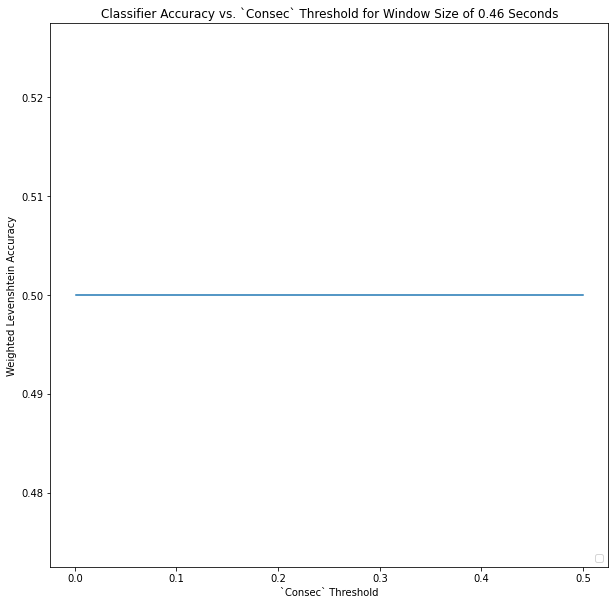

In [15]:
best_heights = []
best_value = 0
for acc in ave_accuracies_per_consec_val.values():
    if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
        best_value = acc

for key, value in ave_accuracies_per_consec_val.items():
    if round(value, 5) == round(best_value, 5):
        best_heights.append(key)

plt.figure(figsize=(10, 10))
plt.plot(ave_accuracies_per_consec_val.keys(), ave_accuracies_per_consec_val.values())
#plt.vlines(best_heights[0], 0, best_value, linestyle=":", label=f"Best Ranges: {round(best_heights[0], 2)} to {round(best_heights[len(best_heights) - 1], 2)}, Accuracy = {round(best_value, 2)}")
#plt.vlines(best_heights[len(best_heights) - 1], 0, best_value, linestyle=":")
#plt.axvspan(best_heights[0], best_heights[len(best_heights) - 1], alpha=0.1, color='red')

plt.legend(loc = "lower right")
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("`Consec` Threshold")
plt.title("Classifier Accuracy vs. `Consec` Threshold for Window Size of 0.46 Seconds")
plt.show()

In [20]:
best_consecs = []
best_value = 0
for wav_values in all_accuracies.values():
    for value in wav_values:
        if round(value, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = value

for key, value in all_accuracies.items():
    if round(value, 5) == round(best_value, 5):
        best_consecs.append(key)

print("Best consec threshold values:", best_consecs)
print("Accuracy with best consec threshold:", all_accuracies[best_consecs[0]])

TypeError: type list doesn't define __round__ method